In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/englishvietnamese-translation/vi_sents
/kaggle/input/englishvietnamese-translation/en_sents


# Preprocess
pipeline chuẩn:

1. Giải nén & load song song source–target
2. Normalize text (unicode, lowercase, whitespace)
3. Loại câu rỗng / quá dài
4. Thêm token đặc biệt <sos>, <eos>
5. Tokenization
* Word-level (LSTM/GRU) hoặc
* BPE/SentencePiece (Transformer – khuyên dùng)

6. Encode text → token ids
7. Padding theo max length
8. Tạo:
* Encoder input
* Decoder input (shift right)
* Decoder output (shift left)

9. (Optional) Filter theo độ dài

## 1. Giải nén & load data

In [2]:
data_path = "/kaggle/input/englishvietnamese-translation"

with open(f"{data_path}/en_sents", encoding = "utf-8") as f:
    en_sents = f.read().strip().split("\n")
with open(f"{data_path}/vi_sents", encoding = "utf-8") as f:
    vi_sents = f.read().strip().split("\n")
assert len(en_sents) == len(vi_sents)
print(f"Length: {len(en_sents)}")
print(en_sents[0])
print(vi_sents[0])

Length: 254090
Please put the dustpan in the broom closet
xin vui lòng đặt người quét rác trong tủ chổi


## 2. Normalize text

In [3]:
import unicodedata
import re
def normalize_text(text):
    text = unicodedata.normalize("NFKC", text)
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    return text
clean_en, clean_vi = [], []
for en_text, vi_text in zip(en_sents, vi_sents):
    en_text = normalize_text(en_text)
    vi_text = normalize_text(vi_text)
    if len(en_text) and len(vi_text):
        clean_en.append(en_text)
        clean_vi.append(vi_text)
assert len(clean_en) == len(clean_vi)

""" Add special tokens"""
def add_special_tokens(text, src = False, sos = "<sos>", eos = "<eos>"):
    if  not src:
        return f"{sos} {text} {eos}"
    else: return f"{text} {eos}"
src_texts = [add_special_tokens(s, True) for s in clean_en]
tgt_texts = [add_special_tokens(s) for s in clean_vi]

"""Tokenize / Make vocab"""
from collections import Counter

def build_vocab(sentences, min_freq = 2):
    counter = Counter()
    for sentence in sentences:
        counter.update(sentence.split())
    vocab = {
        "<pad>" : 0,
        "<unk>" : 1
    }
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

src_vocab = build_vocab(src_texts)
tgt_vocab = build_vocab(tgt_texts)


In [4]:
"""numericalize"""
def stoi(texts, vocab):
    outputs = []
    for text in texts:
        output = []
        for word in text.split():
            output.append(vocab[word] if word in vocab else vocab["<unk>"])
        outputs.append(output)
    return outputs
def itos(idx, vocab):
    pass
src_ids = stoi(src_texts, src_vocab)
tgt_ids = stoi(tgt_texts, tgt_vocab)
"""tgt_input and tgt_label"""
tgt_input_id = [tgt_text_id[:-1] for tgt_text_id in tgt_ids]
tgt_label_id = [tgt_text_id[1:] for tgt_text_id in tgt_ids]

In [5]:
from torch.utils.data import Dataset

class TranslationDataset(Dataset):
    def __init__(self, src_ids, tgt_input_id, tgt_label_id):
        assert len(src_ids) == len(tgt_input_id) == len(tgt_label_id)
        self.src_ids = src_ids
        self.tgt_input_id = tgt_input_id
        self.tgt_label_id = tgt_label_id

    def __len__(self):
        return len(self.src_ids)

    def __getitem__(self, idx):
        return (
            self.src_ids[idx],        # List[int]
            self.tgt_input_id[idx],  # List[int]
            self.tgt_label_id[idx],  # List[int]
        )

In [6]:
def collate_fn(batch, pad_id = 0):
    """
    batch: List of tuples
    [
    (src_batch, tgt_input_batch, tgt_label_batch),
    ...
    ]
    """
    src_batch, tgt_input_batch, tgt_label_batch = zip(*batch)

    #tim max length trong tunwgf batch
    src_max_len = max(len(seq) for seq in src_batch)
    tgt_max_len = max(len(seq) for seq in tgt_input_batch)

    # Pad source
    padded_src = [
        seq + [pad_id]* (src_max_len - len(seq)) for seq in src_batch
    ]
    # Pad tgt_input
    padded_tgt_input = [
        seq + [pad_id]* (tgt_max_len - len(seq)) for seq in tgt_input_batch
    ]
    # Pad source
    padded_tgt_label = [
        seq + [pad_id]* (tgt_max_len - len(seq)) for seq in tgt_label_batch
    ]
    return (
        torch.tensor(padded_src, dtype = torch.long),
        torch.tensor(padded_tgt_input, dtype = torch.long),
        torch.tensor(padded_tgt_label, dtype = torch.long),
    )

In [7]:
from torch.utils.data import DataLoader

dataset = TranslationDataset(
    src_ids,
    tgt_input_id,
    tgt_label_id
)

dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

# Encoder Decoder

In [8]:
from torch import nn
import torch

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X, *args):
        raise NotImplementedError
        
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
    def init_state(self, enc_all_ouputs, *args):
        raise NotImplementedError
    def forward(self, X, state):
        raise NotImplementedError



# GRU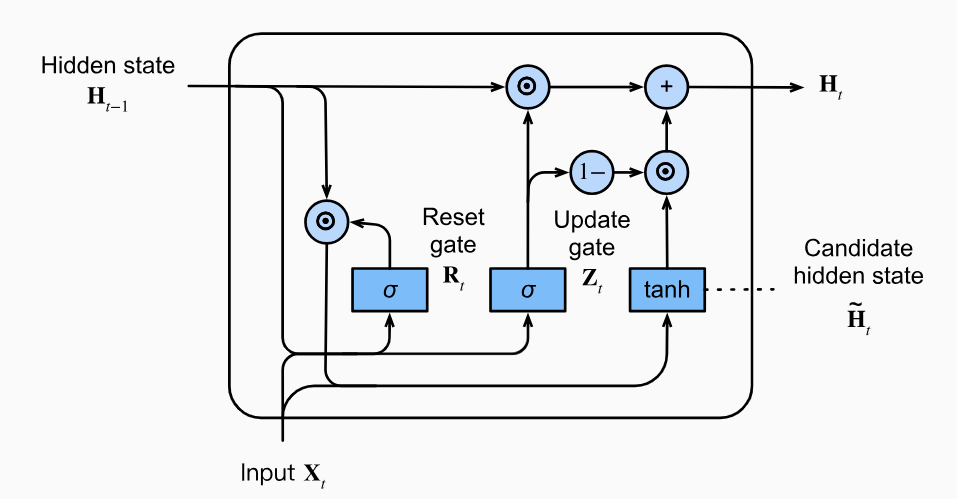
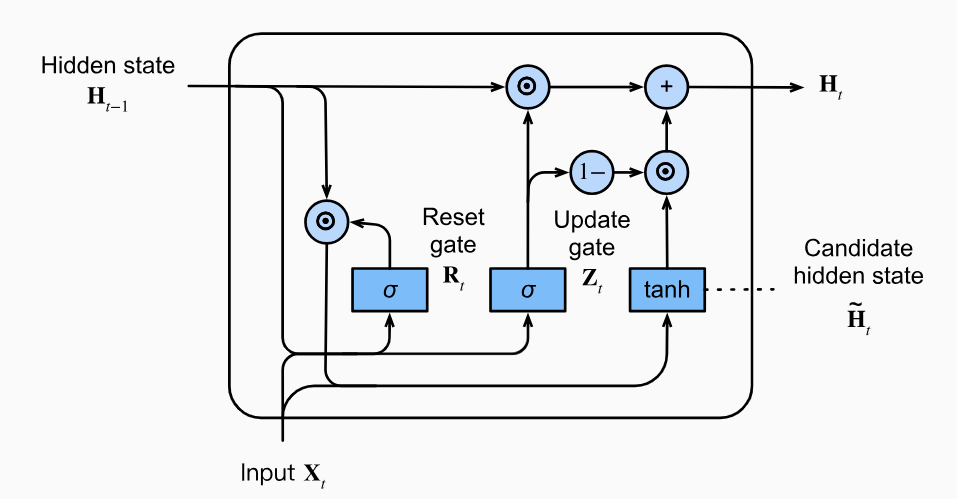

In [10]:
class GRU(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout = 0.0):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)

        self.layers = nn.ModuleList()
        for i in range(num_layers):
            input_size = num_inputs if i == 0 else num_hiddens
            self.layers.append(GRUCell(input_size, num_hiddens))
        
    def forward(self, inputs, state = None):
        if state is None:
            state = [torch.zeros((inputs.shape[1], self.num_hiddens),
                           device = inputs.device) for _ in range(self.num_layers)]
        outputs = []
        for X in inputs:
            new_state = []
            for i, layer in enumerate(self.layers):
                H = state[i]
                Z = torch.sigmoid(torch.matmul(X, layer.W_xz) +
                                torch.matmul(H, layer.W_hz) + layer.b_z)
                R = torch.sigmoid(torch.matmul(X, layer.W_xr) +
                                torch.matmul(H, layer.W_hr) + layer.b_r)
                H_tilde = torch.tanh(torch.matmul(X, layer.W_xh) +
                                   torch.matmul(R * H, layer.W_hh) +layer.b_h)
                H = Z * H + (1 - Z) * H_tilde
                new_state.append(H)
                X = self.dropout(H)
            state = new_state
            outputs.append(X)
        return torch.stack(outputs), torch.stack(state)
class GRUCell(nn.Module):
    def __init__(self, num_inputs, num_hiddens, sigma = 0.01):
        super().__init__()
        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                      init_weight(num_hiddens, num_hiddens),
                      nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple()  #update gate
        self.W_xr, self.W_hr, self.b_r = triple()  #reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  #candidate hidden state

# Seq2Seq encoder decoder

In [11]:
class Seq2SeqEncoder(Encoder):  #@save
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = GRU(embed_size, num_hiddens, num_layers, dropout)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state
class Seq2SeqDecoder(Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int64))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]
class Seq2Seq(nn.Module):
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        return self.decoder(dec_X, dec_state)[0]


In [12]:
len(src_vocab)

13307

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
PAD_ID = tgt_vocab["<pad>"]

embed_size = 256
num_hiddens = 256
num_layers = 2
dropout = 0.1

encoder = Seq2SeqEncoder(
    vocab_size = len(src_vocab),
    embed_size = embed_size,
    num_hiddens = num_hiddens,
    num_layers = num_layers,
    dropout = dropout
)
decoder = Seq2SeqDecoder(
    vocab_size = len(tgt_vocab),
    embed_size = embed_size,
    num_hiddens = num_hiddens,
    num_layers = num_layers,
    dropout = dropout
)
model = Seq2Seq(encoder, decoder).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [15]:
len(dataloader)

7941

In [16]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for src, tgt_input, tgt_label in dataloader:
        #move the data into device
        src = src.to(device)
        tgt_input = tgt_input.to(device)
        tgt_label = tgt_label.to(device) #shape = (batch_size, sequence_len) với mỗi phần tử là id chính xác

        optimizer.zero_grad()

        logits = model(src, tgt_input)
        """
        nn.CrossEntropyLoss yêu cầu về input và target như sau:
        input.shape = (N, C)
            N: số mẫu cần tính loss
            C: số class
        target.shape = (N,) tức mỗi phần tử là index class đúng

        Hiện tại, phải phân tích dim của logits và tgt_label.
        * logits: output của model sẽ có chiều là (batch_size, num_steps, vocab_size)
            ta muốn nó về (N, C) tức là đưa về dạng (batch_size * num_steps, vocab_size)
            GPT dùng công thức logits.reshape(-1, logits.size(-1))
            công thức này có nghĩa là, logits sẽ được reshape thành 2 chiều, 
                chiều đầu tiên sẽ được "tự suy ra"
                chiều thứ hai chính là vocab_size, vậy nên mặc định chiều thứ nhất sẽ bị flatten vào.
        * tgt_label hiện đang có chiều là (batch_size, sequence_len)
            ==> ta chỉ cần flatten nó ra thôi
        """
        loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_label.reshape(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

Epoch [1/20] - Loss: 2.1038
Epoch [2/20] - Loss: 1.3511
Epoch [3/20] - Loss: 1.1925
Epoch [4/20] - Loss: 1.1076
Epoch [5/20] - Loss: 1.0522
Epoch [6/20] - Loss: 1.0136
Epoch [7/20] - Loss: 0.9834
Epoch [8/20] - Loss: 0.9592
Epoch [9/20] - Loss: 0.9399
Epoch [10/20] - Loss: 0.9233
Epoch [11/20] - Loss: 0.9102
Epoch [12/20] - Loss: 0.8991
Epoch [13/20] - Loss: 0.8898
Epoch [14/20] - Loss: 0.8814
Epoch [15/20] - Loss: 0.8741
Epoch [16/20] - Loss: 0.8672
Epoch [17/20] - Loss: 0.8616
Epoch [18/20] - Loss: 0.8580
Epoch [19/20] - Loss: 0.8542
Epoch [20/20] - Loss: 0.8499
